# Using CReM in combination with machine learning models

This tutorial will exemplify the use of CReM in combination with machine learning models in optimization of a randomly chosen initial structure to a structure having high predicted end-point value. You may choose another starting molecule and look at the output.

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, DataStructs
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
IPythonConsole.molSize = (400,300)
IPythonConsole.ipython_useSVG=True

from crem.crem import mutate_mol

import numpy as np
from sklearn.ensemble import RandomForestRegressor

RDKit WARNING: [11:38:12] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# auxiliary functions to draw molecules with highlighting atoms 
def drawsvg(mol, highlightAtoms=[], highlightReplacement=False, molSize=(400, 300), kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        AllChem.Compute2DCoords(mc)
    if highlightReplacement:
        ids = []
        for a in mol.GetAtoms():
            if 'react_atom_idx' not in a.GetPropsAsDict():
                ids.append(a.GetIdx())
        if ids:
            highlightAtoms = ids
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc, highlightAtoms=highlightAtoms)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))


def drawgrid(mols, highlight=0):
    """
    highlight: 0 - no highlight
               1 - highlight changed atoms
               2 - highlight unchanged atoms
    """
    if highlight == 0:
        return Draw.MolsToGridImage(mols[:8], molsPerRow=4, subImgSize=(300,200), useSVG=True)
    else:
        ids_list = []
        for m in mols:
            ids = []
            for a in m.GetAtoms():
                if 'react_atom_idx' not in a.GetPropsAsDict():
                    ids.append(a.GetIdx())
            if highlight == 1:
                ids_list.append(ids)
            elif highlight == 2:
                ids_list.append(list(set(range(m.GetNumAtoms())) - set(ids)))
        return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,200), 
                                    highlightAtomLists=ids_list, useSVG=True)

In [3]:
def rdkit_numpy_convert(fp):
    # fp - list of binary fingerprints
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)

def get_top(ms, model):
    # ms - list of molecules
    # model - sklearn model
    fps1 = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in ms]
    x1 = rdkit_numpy_convert(fps1)
    pred = model.predict(x1)
    i = np.argmax(pred)
    return ms[i], pred[i]

def get_sim(ms, ref_fps):
    # ms - list of molecules
    # ref_fps - list of fingerprints of reference molecules
    output = []
    fps1 = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in ms]
    for fp in fps1:
        v = DataStructs.BulkTanimotoSimilarity(fp, ref_fps)
        i = np.argmax(v)
        output.append([v[i], i])
    return output

In this section we will:
- load structures of molecules with measured pKi values for histamine H1 receptor.
- create Random Forest model based on binary Morgan fingerprints

In [4]:
# read file with compounds  and their pKi value for 5-HT1a receptor
mols = []
names = []
y = []
with open('CHEMBL231.smi') as f:
    for line in f:
        smi, name, act = line.strip().split()
        m = Chem.MolFromSmiles(smi)
        if m:
            mols.append(m)
            names.append(name)
            y.append(float(act))

In [5]:
# create binary Morgan fingeprints and X matrix to train model
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mols]
x = rdkit_numpy_convert(fps)

In [6]:
# train Random forest model
# (here we do not optimize hyperparameters which is required for real use cases, this can be done with for example GridSearchCV)
m = RandomForestRegressor(n_estimators=100, n_jobs=2, random_state=42, oob_score=True)
m.fit(x, y)

RandomForestRegressor(n_jobs=2, oob_score=True, random_state=42)

In [7]:
# out-of-bag score can be considered as a measure of predictivy of a model
# (in real use cases cross-validation or external test set would be preferable)
m.oob_score_

0.7314209965191422

Let's implement a naive gready search algorithm. It will start from a given molecule. On each iteration the input molecule will be mutated using the corresponding CReM function. Activity of derived molecules will be estimated with the previosuly obtained model and the molecule with the highest score will be taken for the next iteration. The procedure will be reapeated until the improvement in the predicted end-point value will be observed.

In [8]:
# specify the path to the fragment database (replace with your actual path)
db_fname = 'replacements02_sc2.db'

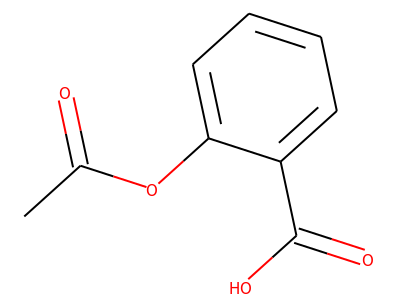

In [9]:
# let's start from aspirin
mol = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
mol

In [10]:
# estimate end-point value for aspirin
get_top([mol], m)[1]

6.02255

molecules generated: 489
best score: 8.272


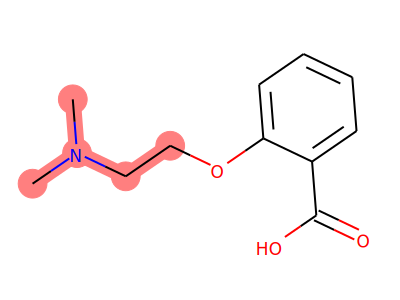

In [11]:
# iteration 1
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 711
best score: 8.533


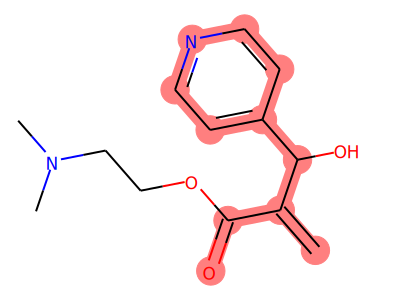

In [12]:
# iteration 2
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 512
best score: 8.666


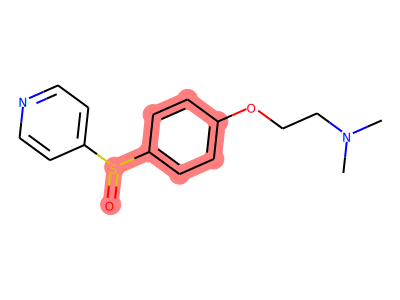

In [13]:
# iteration 3
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 6159
best score: 8.781


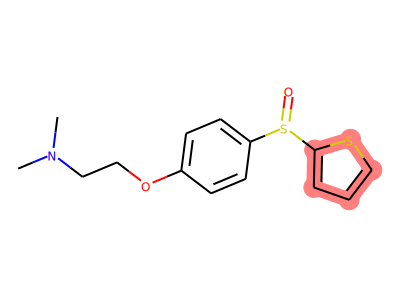

In [14]:
# iteration 4
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 5090
best score: 8.842


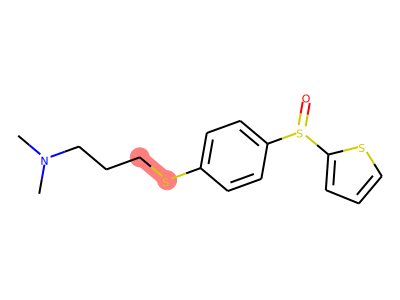

In [15]:
# iteration 5
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 6106
best score: 8.888


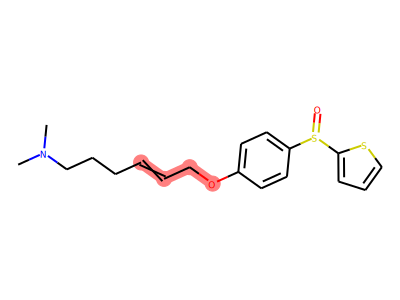

In [16]:
# iteration 6
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 4367
best score: 8.924


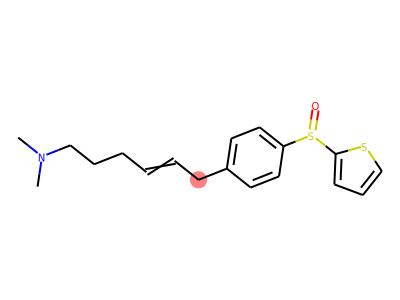

In [17]:
# iteration 7
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 5574
best score: 8.924


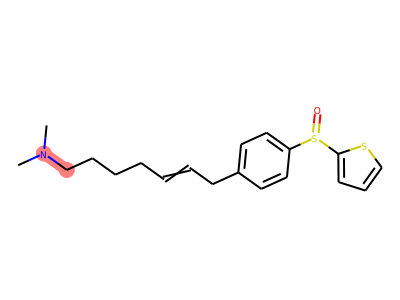

In [18]:
# iteration 8
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 4579
best score: 8.951


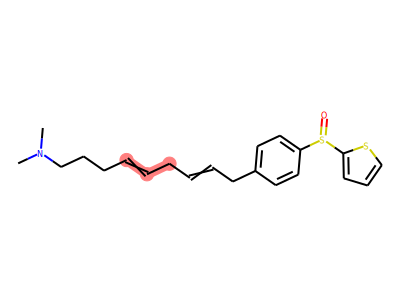

In [19]:
# iteration 9
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

molecules generated: 3625
best score: 8.951


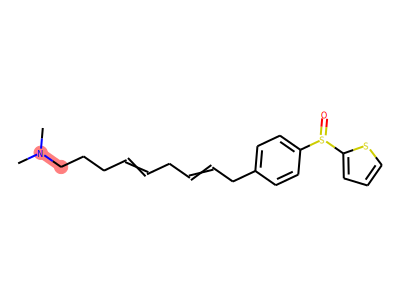

In [20]:
# iteration 10
mol = best_mol
new_mols = list(mutate_mol(Chem.AddHs(mol), db_name=db_fname, return_mol=True, min_size=0, max_size=8, min_inc=-3, max_inc=3, ncores=4))
new_mols = [Chem.RemoveHs(i[1]) for i in new_mols]
best_mol, score = get_top(new_mols + [mol], m)
print('molecules generated:', len(new_mols))
print('best score:', np.round(score, 3))
drawsvg(best_mol, highlightReplacement=True)

In [21]:
# calculate similarity of our best molecules to structures in the initila dataset (we use Tanimoto on Morgan binary fingerprints)
get_sim([best_mol], fps)

[[0.25862068965517243, 847]]

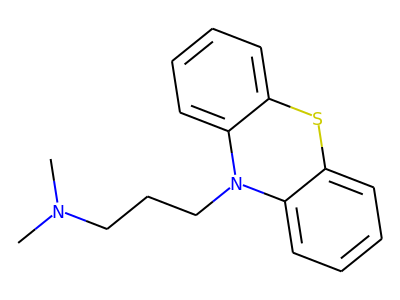

In [22]:
# this is the closest molecule from the training set
mols[847]

The designed molecule has low similarity to the training set ones and thus can be considered as novel. It has some structural patterns similar to training set compounds but it is unlikely that this compounds will be really active on the H1 receptor. At least the molecule has a very long flexible chain that can make binding entropy very unvaforable.
This is just a demonstration how to create optimization workflows using CReM. To combine with machine learning models it is always needed to consider applicabiity domain of used models. Otherwise models can be optimized to a particular local optimum which is not reasonable from structural point of view and represent just an artefact.
Instead of ML models any other predictive model or their combination can be used (docking, pharmacophore, etc).